In [1]:
#|hide
#|eval: false
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [9]:
#|hide
#|eval: false
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [10]:
#|default_exp agents.dqn.dueling

In [11]:
#|export
# Python native modules
import os
from collections import deque
# Third party libs
from fastcore.all import *
import torchdata.datapipes as dp
from torch.utils.data.dataloader_experimental import DataLoader2
from torch.utils.data.datapipes._typing import _DataPipeMeta, _IterDataPipeMeta
from torchdata.dataloader2.graph import find_dps,traverse,DataPipe,replace_dp,remove_dp
# Local modules
import torch
from torch.nn import *
import torch.nn.functional as F
from torch.optim import *
from fastai.torch_basics import *
from fastai.torch_core import *

from fastrl.core import *
from fastrl.agents.core import *
from fastrl.pipes.core import *
from fastrl.data.block import *
from fastrl.memory.experience_replay import *
from fastrl.agents.core import *
from fastrl.agents.discrete import *
from fastrl.loggers.core import *
from fastrl.loggers.vscode_visualizers import *
from fastrl.learner.core import *
from fastrl.agents.dqn.basic import *
from fastrl.agents.dqn.target import *

# DQN Dueling
> DQN using a split head for comparing the davantage of different actions



## Training DataPipes

In [5]:
#|export
class DuelingHead(nn.Module):
    def __init__(self,
            hidden:int, # Input into the DuelingHead, likely a hidden layer input
            n_actions:int, # Number/dim of actions to output
            lin_cls=nn.Linear
        ):
        super().__init__()
        self.val=lin_cls(hidden,1)
        self.adv=lin_cls(hidden,n_actions)

    def forward(self,xi):
        val,adv=self.val(xi),self.adv(xi)
        xi=val.expand_as(adv)+(adv-adv.mean()).squeeze(0)
        return xi

Try training with basic defaults...

In [7]:
from fastrl.envs.gym import *
from fastrl.agents.dqn.target import *
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2,head_layer=DuelingHead) #.cuda()
# Setup the Agent
agent = DQNAgent(model,[logger_base],max_steps=4000)#,device='cuda')
# Setup the DataBlock
block = DataBlock(
    GymTransformBlock(agent=agent,nsteps=1,nskips=1,firstlast=False,n=1000,bs=1)
)
# pipes = L(block.datapipes(['CartPole-v1']*1,n=10))
dls = L(block.dataloaders(['CartPole-v1']*1))
# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=[logger_base],bs=128,max_sz=100_000,
                    dp_augmentation_fns=[
                        TargetModelUpdater.insert_dp(),
                        TargetModelQCalc.replace_dp()
                    ])
learner.fit(3)
# learner.fit(25)

loss,episode,rolling_reward,epoch,batch,epsilon
0.02459141,52,19.509804,1,1000,0.749500
0.084531255,93,21.500000,2,1000,0.499250
0.15238045,105,28.840000,2,1000,0.249250


The DQN learners, but I wonder if we can get it to learn faster...

In [12]:
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2,head_layer=DuelingHead)
# Setup the Agent
agent = DQNAgent(model,[logger_base],max_steps=10000)
# Setup the DataBlock
block = DataBlock(
    GymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True,n=1000,bs=1), # We basically merge 2 steps into 1 and skip. 
    (GymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True,n=100,include_images=True),VSCodeTransformBlock())
)
dls = L(block.dataloaders(['CartPole-v1']*1))
# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=[logger_base],bs=128,max_sz=20_000,nsteps=2,lr=0.001,
                    dp_augmentation_fns=[
                        TargetModelUpdater.insert_dp(),
                        TargetModelQCalc.replace_dp()
                    ])
learner.fit(3)
# learner.fit(10)

loss,episode,rolling_reward,epoch,batch,epsilon
0.24247332,72,28.780000,1,1000,0.810000
2.1317954,110,45.080000,2,1000,0.615800
3.3318765,133,71.960000,2,1000,0.419400


/opt/conda/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


Creating gif from 100 frames


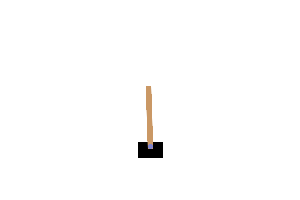

In [13]:
learner.validate()

In [14]:
#|hide
#|eval: false
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()

/opt/conda/lib/python3.7/site-packages/astroid/node_classes.py:96: DeprecationWarning: The 'astroid.node_classes' module is deprecated and will be replaced by 'astroid.nodes' in astroid 3.0.0
  DeprecationWarning,
